# **Importations** et chargement des données nettoyées

In [1]:
# %%flake8  # checking PEP8 compliance

# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import folium
import seaborn as sns
import numpy as np
import pickle

from sklearn.preprocessing import OneHotEncoder, StandardScaler 

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
  from google.colab import drive
  drive.mount('/content/drive/')
  IN_COLAB = True
except:
  IN_COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
!git clone https://github.com/SmadjaPaul/Library_DS.git
#%load work_dir + Library_DS/functions_p5.py
!git -C "Library_DS" pull
%load "Library_DS/functions_p5.py"
import Library_DS.functions_p5 as functions_p5

Cloning into 'Library_DS'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 56 (delta 16), reused 6 (delta 1), pack-reused 0
Unpacking objects: 100% (56/56), done.
Already up to date.


In [4]:
# %%flake8  # checking PEP8 compliance
import os
from IPython.display import display

if IN_COLAB == True:
  dir_name = "/content/drive/My Drive/OPC/perso/POLIST_final/data/save/"
  model_dir = "/content/drive/My Drive/OPC/perso/POLIST_final/data/models/"
  images_dir = "/content/drive/My Drive/OPC/perso/POLIST_final/data/images/"
else:
  dir_name = "data/save/"
  model_dir = "data/models/"
  images_dir = "data/images/"

# Load file with cleaned data
data_PCA = pd.read_csv(dir_name + "p5_data_PCA.csv")
data_cleaned = pd.read_csv(dir_name + "data_cleaned.csv")
data_cleaned_std = pd.read_csv(dir_name + "data_cleaned_std.csv")
# Set maximum number of columns
pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999

## **Échantillonage** aléatoire

In [5]:
data_PCA = data_cleaned_std

In [6]:
# %%flake8  # checking PEP8 compliance

import random
from random import randrange

# Set random integer (seed)
seed = random.randrange(1000)

# Initialize the seed of pseudo-random generator
random.seed(seed)
print("Seed value: ", seed)

Seed value:  87


In [7]:
# Sampling from data_PCA
X_std = data_PCA.sample(n=10000, random_state=seed)

## **Réductions dimensionnelles** (tSNE, PCA et Isomap)

In [8]:
# %%flake8  # checking PEP8 compliance

# Import libraries
from sklearn import manifold
from sklearn import decomposition

# Instanciation of the embeddings
# -------------------------------

# Instanciation of t-SNE
tsne = manifold.TSNE(
            n_components=2,  # for projection in a plane
            perplexity=30,
            n_iter=300,
            init='pca',  # initialisation by a PCA
            random_state=0
        )

# Instanciation of Isomap
isomap = manifold.Isomap(
            n_components=2  # for projection in a plane
        )

# Instanciation of PCA
pca = decomposition.PCA(
            n_components=2  # for projection in a plane
        )

# Applying the embedding algorithm
X_tsne = tsne.fit_transform(X_std)
X_isomap = isomap.fit_transform(X_std)
X_pca = pca.fit_transform(X_std)

# **Segmentations**

In [9]:
# Sampling from data_PCA
X_std = data_PCA.sample(n=10000, random_state=seed)

## **Modèle naïf :** bissection aléatoire
Dans ce modèle naïf, nous considérons une segmentation aléatoire en deux groupes. Cela nous donne un score de référence (*'baseline'*).

### Évaluations avec coefficient de silhouette *s*

Coefficient de silhouette *s* d'une segmentation : $ s = \frac{1}{n} \sum\limits_{i=1}^n s(x^{(i)})$, avec :

* $ s(x) = \frac{b(x)-a(x)}{\max(a(x) , b(x))}$ : coefficient de silhouette du point *x*

* $ \underset{(x ∈ C_k)}{a(x)} = \frac{1}{|C_k|-1} \sum\limits_{\underset{u \neq x}{u ∈ C_k}} \mathrm{d}(u, x)$ : distance moyenne du point *x* aux autres points du même cluster

* $ b(x) = \min_{\substack{l \neq k}} \frac{1}{|C_l|} \sum\limits_{u ∈ C_l} \mathrm{d}(u, x)$ : distance moyenne du point *x* aux autres points du cluster le plus proche

In [10]:
# %%flake8  # checking PEP8 compliance

def gini(clusters_labels):
    """Compute the Gini coefficient for a clustering.
    Parameters:
        - clusters_labels: pd.Series of labels of clusters for each point.
    """

    # Get frequencies from clusters_labels
    clusters_labels = pd.Series(clusters_labels)
    frequencies = clusters_labels.value_counts()

    # Mean absolute difference
    mad = frequencies.mad()

    # Mean frequency of clusters
    mean = frequencies.mean()

    # Gini coefficient
    gini_coeff = 0.5 * mad / mean

    return gini_coeff

In [11]:
# %%flake8  # checking PEP8 compliance

# Initializing DataFrame of results
global results_df
results_df = pd.DataFrame()


def metrics_clustering(algorithm_name,
                       standardized_features,
                       clusters_labels,
                       results_df):

    from sklearn import metrics

    # Number of clusters
    # -------------------------------------------
    nb_clusters = len(set(clusters_labels)) \
        - (1 if -1 in clusters_labels else 0)
    nb_clusters = int(nb_clusters)
    print('Estimated number of clusters (excluding noise): %d' % nb_clusters)
    results_df.loc[algorithm_name, 'Nb of clusters'] = nb_clusters

    # Silhouette score
    # -------------------------------------------
    silhouette = metrics.silhouette_score(
        standardized_features,
        clusters_labels
    )
    print("\nSilhouette coefficient: s = {:.3f}".format(silhouette))
    print("  Notice: values closer to 1 indicate a better partition")
    results_df.loc[algorithm_name, 'Silhouette'] = silhouette

    # Gini coefficient
    # --------------------------------------------
    gini_coeff = gini(clusters_labels)
    print("\nGini coefficient: G = {:.3f}".format(gini_coeff))
    print("  Notice: values closer to 0 indicate \
    homogenic frequencies for clusters.")
    results_df.loc[algorithm_name, 'Gini'] = gini_coeff

    # Sorting the pd.DataFrame of results
    results_df = results_df.sort_values('Silhouette', ascending=False)

    print("")
    return results_df

In [12]:
# %%flake8  # checking PEP8 compliance

algorithm_name = 'Naïve model'
standardized_features = X_std

# Random labels (0 or 1)
clusters_labels = np.random.randint(2, size=len(standardized_features))

metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 2

Silhouette coefficient: s = -0.000
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.004
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
Naïve model,2.0,-0.000057,0.0037


## **Ségmentation hiérarchique** (*hierarchical clustering*)

In [13]:
# %%flake8  # checking PEP8 compliance

import numpy as np
from sklearn.base import BaseEstimator
import time


class GridSearch(BaseEstimator):
    """Classe permettant d'implémenter une recherche exhaustive sur grille
    (sans validation croisée) pour les algorithmes de clustering."""

    # Method: init
    # ------------------------------------------------------------------------------
    def __init__(
            self,
            estimator,  # clustering algorithm to test
            param_grid,  # research space for hyperparameters
            scoring=None):
        """Méthode d'initialisation prenant en entrée le modèle
        à tester et la grille de paramètres."""

        # getting parameters
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring

    # Method: fit
    # ------------------------------------------------------------------------------
    def fit(self, X):
        """Méthode permettant de réaliser la recherche sur grille,
        et renvoyant le meilleur modèle trouvé, ré-entraîné sur les données."""

        # initialization of the dict of results
        self.results_ = {"scores": [],
                         "params": [],
                         "models": [],
                         "fit_times": [],
                         "nb_clusters": [],
                         "gini_coef": []}

        # Loading modules
        from sklearn.model_selection import ParameterGrid

        # iterating upon all combinations of parameters
        for param_combination in ParameterGrid(param_grid):
            # instanciation of the model with selected parameters
            model = self.estimator(**param_combination)

            # Measuring training time while fitting the model on the data
            #time_train = timeit.timeit( model.fit(X), number=1)
            #time_train = time_train.average
            t0 = time.time()
            model.fit(X)
            time_train = time.time() - t0
            # Scoring the model
            if not self.scoring:  # if scoring parameter not defined
                model_score = model.score(X)
            else:  # if scoring parameter is defined
                try:
                    labels = model.labels_
                    model_score = self.scoring(X, labels)
                except:
                    model_score = np.nan

            # Computing number of clusters, excluding noise (#-1)
            nb_clusters = \
                len(set(model.labels_)) - (1 if -1 in clusters_labels else 0)
            nb_clusters = int(nb_clusters)

            # Computing Gini coefficient
            gini_coeff = gini(model.labels_)

            # saving results, parameters and models in a dict
            self.results_["scores"].append(model_score)  # scores
            self.results_["params"].append(param_combination)  # parameters
            self.results_["models"].append(model)  # trained models
            self.results_["fit_times"].append(time_train)  # training time
            self.results_["gini_coef"].append(gini_coeff)  # Gini coefficient
            self.results_["nb_clusters"].append(nb_clusters)  # nb of clusters

        # Selecting best model (assumes that 'greater is better')
        # -----------------------------------
        best_model_index, best_score = None, None  # initialisation
        # iterating over scores
        for index, score in enumerate(self.results_["scores"]):

            # initialisation
            if not best_score:
                best_score = score
                best_model_index = index

            # if score is better than current best_score
            if score > best_score:
                # update the current best_score and current best_model_index
                best_score = score
                best_model_index = index

        # Update attributes of the instance
        self.best_score_ = self.results_["scores"][best_model_index]
        self.best_params_ = self.results_["params"][best_model_index]
        self.best_estimator_ = self.results_["models"][best_model_index]
        self.best_index_ = best_model_index
        self.refit_time_ = self.results_["fit_times"][best_model_index]

        return self

    # Method: predict
    # ------------------------------------------------------------------------------
    def predict(self, X_test):
        """Méthode permettant de réaliser les prédictions sur le jeu de test,
        en utilisant le meilleur modèle trouvé avec la méthode .fit
        entraîné sur le jeu d'entraînement complet."""

        # use the .predict method of the estimator on the best model
        return self.best_model.predict(X_test)

### Définition de l'espace de recherche

In [14]:
# %%flake8  # checking PEP8 compliance

# Definition of the search space for hyperparameters
param_grid = [
    {
        # number of clusters to find
        'n_clusters': range(4, 10),
        # linkage criterion to use
        'linkage': ['complete', 'average', 'single'],
        # Metric used to compute the linkage
        'affinity': ['euclidean', 'manhattan', 'cosine']
    },

    {
        'n_clusters': range(4, 10),  # number of clusters to find
        'linkage': ['ward'],  # linkage criterion to use
    }
]

### Sélection des hyper-paramètres

In [15]:
# %%flake8  # checking PEP8 compliance

# importing modules
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
hierarchy_search = GridSearch(
    estimator=AgglomerativeClustering,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
hierarchy_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", hierarchy_search.best_params_)
print("Best Silhouette score:", hierarchy_search.best_score_)
print("Training time:", hierarchy_search.refit_time_)

Best hyperparameters: {'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 4}
Best Silhouette score: 0.6911279287065678
Training time: 1.7305092811584473


In [16]:
pd.DataFrame(hierarchy_search.results_)

,scores,params,models,fit_times,nb_clusters,gini_coef
0,0.668382,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.435160,4,0.748400
1,0.465067,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.393747,5,0.792600
2,0.464397,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.433789,6,0.825933
3,0.363742,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.418495,7,0.841343
4,0.363740,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.405675,8,0.859200
5,0.372534,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.411036,9,0.863189
6,0.668382,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",3.558285,4,0.748400
7,0.667854,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",3.499023,5,0.798400
8,0.648912,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",3.527086,6,0.831733
9,0.471186,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",3.520080,7,0.852043


### Dendrogramme avec Scipy


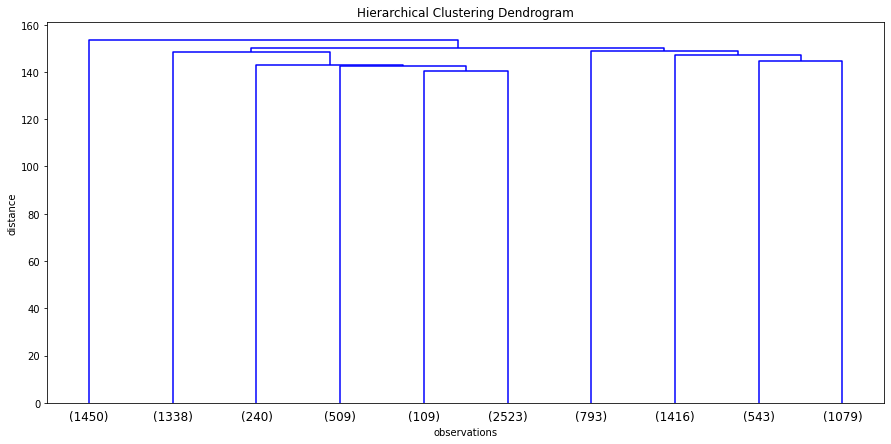

In [17]:
# %%flake8  # checking PEP8 compliance
from scipy.cluster.hierarchy import linkage


def plot_dendrogram(Z, labels=[], p=10):
    """This function plots the dendogram.
    Parameters:
    ----------
        - Z : linkage. Ex: Z = linkage(X_std, 'ward')
        - labels : names of the points
        - p : numbers of clusters to stop"""

    from scipy.cluster.hierarchy import dendrogram

    plt.figure(figsize=(15, 7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('observations')
    plt.ylabel('distance')
    dendrogram(
        Z,
        p=p,
        # labels = names,
        truncate_mode="lastp"
    )
    plt.show()


# Clustering hiérarchique (critère de Ward)
Z = linkage(X_std, 'ward')

# number of clusters for truncating dendogram
p = 10

# plotting the dendogram
plot_dendrogram(Z, p=p)

### Visualisation par réduction dimensionnelle

In [18]:
# %%flake8  # checking PEP8 compliance


def plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='tSNE',
        ax=None):
    """
    Arguments:
    ---------
    embedding_algo: 'tSNE' or 'PCA' or 'Isomap'
    """

    # Applying the embedding
    # -----------------
    # Import libraries
    from sklearn import manifold
    from sklearn import decomposition

    # Instanciation of the embedding
    if embedding_algo == 'tSNE':
        X_projected = X_tsne

    elif embedding_algo == 'Isomap':
        X_projected = X_isomap

    elif embedding_algo == 'PCA':
        X_projected = X_pca

    # Plotting the Isomap embedding
    # -----------------------------

    # If no axes is passed…
    if not ax:
        # Set the axes to the current one
        ax = plt.gca()  # ax = ax or plt.gca()
        # Set dimensions of the figure (if no axes is passed)
        plt.gcf().set_figwidth(12)
        plt.gcf().set_figheight(7)

    # Definitions of axis boundaries
    ax.set_xlim(X_projected[:, 0].min()*1.1, X_projected[:, 0].max()*1.1)
    ax.set_ylim(X_projected[:, 1].min()*1.1, X_projected[:, 1].max()*1.1)

    # Properties of the axes
    ax.set_title(embedding_algo, fontsize=20)

    if embedding_algo == 'PCA':
        # Names of x- and y- axis, with percentage of explained variance
        ax.set_xlabel('First component ({}%)'
                      .format(round(100*pca.explained_variance_ratio_[0], 1)))
        ax.set_ylabel('Second component ({}%)'
                      .format(round(100*pca.explained_variance_ratio_[1], 1)))
    else:
        ax.set_xlabel('First component')
        ax.set_ylabel('Second component')

    # Setting color
    NB_CLUSTERS = \
        len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    color = clusters_labels / NB_CLUSTERS

    # Setting color to black for noise points
    # color = pd.Series(clusters_labels / NB_CLUSTERS).astype('object')
    # color = color.map(lambda x: x if x != (-1 / NB_CLUSTERS) else 'black')

    # Plotting the scatter plot
    ax.scatter(
            X_projected[:, 0],  # x-coordinate
            X_projected[:, 1],  # y-coordinate
            c=color,  # base for coloration of points
            cmap=plt.cm.get_cmap('Set1'),  # colormap
            )

In [94]:
# %%flake8  # checking PEP8 compliance


def clustering_plots(algorithm_name, standardized_features, clusters_labels):

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    fig = plt.figure()

    # Set properties of the figure
    fig.set_figheight(6)
    fig.set_figwidth(23)
    fig.suptitle('Visualisation of clustering with {}'
                 .format(algorithm_name), fontsize=20)

    # Set the geometry of the grid of subplots
    gs = gridspec.GridSpec(nrows=1, ncols=3,)

    # Initialize axes and set position (left to right, top to bottom)
    # Use sharex or sharey parameter for sharing axis
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Filling the axes
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='tSNE',
        ax=ax1
    )
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='PCA',
        ax=ax2
    )
    plot_clusters(
        standardized_features,
        clusters_labels,
        embedding_algo='Isomap',
        ax=ax3
    )

    # Automatically adjusts subplots params to fit the figure
    gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

    fig.savefig(images_dir + algorithm_name +'embedding.png')

ValueError: ignored

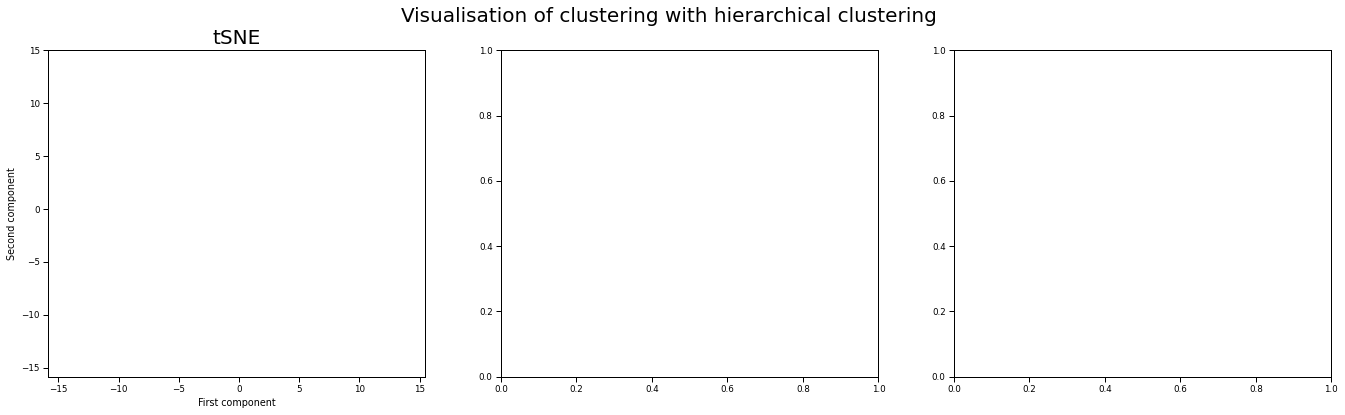

In [99]:
# %%flake8  # checking PEP8 compliance

# Setup for call to the clustering_plots function
algorithm_name = 'hierarchical clustering'
standardized_features = X_std
clusters_labels = hierarchy_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [21]:
# %%flake8  # checking PEP8 compliance

# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 4

Silhouette coefficient: s = 0.691
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.749
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.691128,0.7491
Naïve model,2.0,-0.000057,0.0037


## ***k-MEANS***

### Définition de l'espace de recherche des hyper-paramètres

In [22]:
# %%flake8  # checking PEP8 compliance

# Definition of the search space for hyperparameters
param_grid = {
    "n_clusters":  range(2, 20),  # number of clusters
}

### Application de l'algorithme et ajustement des hyper-paramètres

In [23]:
# %%flake8  # checking PEP8 compliance

# importing modules
from sklearn import cluster
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
kmeans_search = GridSearch(
    estimator=cluster.MiniBatchKMeans,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
kmeans_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", kmeans_search.best_params_)
print("Best Silhouette score:", kmeans_search.best_score_)
print("Training time:", kmeans_search.refit_time_)

Best hyperparameters: {'n_clusters': 12}
Best Silhouette score: 0.23592379560637913
Training time: 0.07435727119445801


### Influence des hyper-paramètres

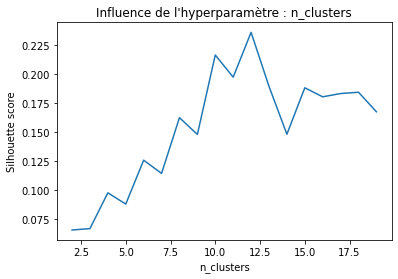

In [24]:
# %%flake8  # checking PEP8 compliance

# Getting the list of parameters and list of scores
n_clusters_list = [kmeans_search.results_['params'][i]['n_clusters']
                   for i in range(len(kmeans_search.results_['params']))]
scores_list = kmeans_search.results_['scores']

# Plotting the influence of the single hyperparameter
x = n_clusters_list
y = scores_list
plt.xlabel("n_clusters")
plt.ylabel("Silhouette score")
plt.title("Influence de l'hyperparamètre : n_clusters")
plt.plot(x, y)

### Réduction dimensionnelle et visualisation

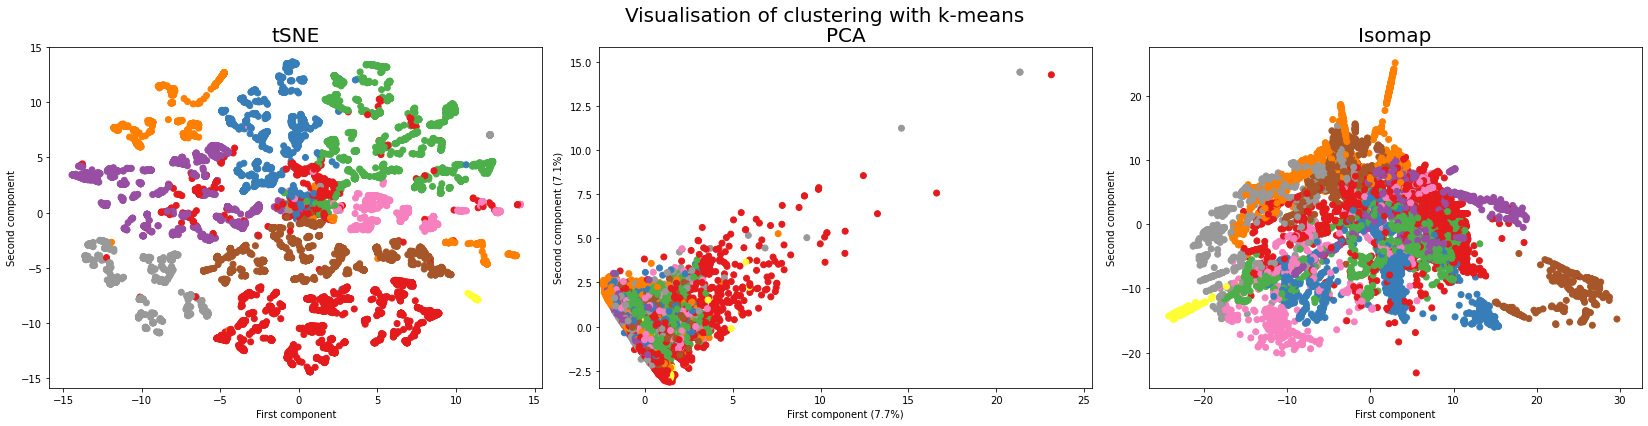

In [25]:
# %%flake8  # checking PEP8 compliance

# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = kmeans_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

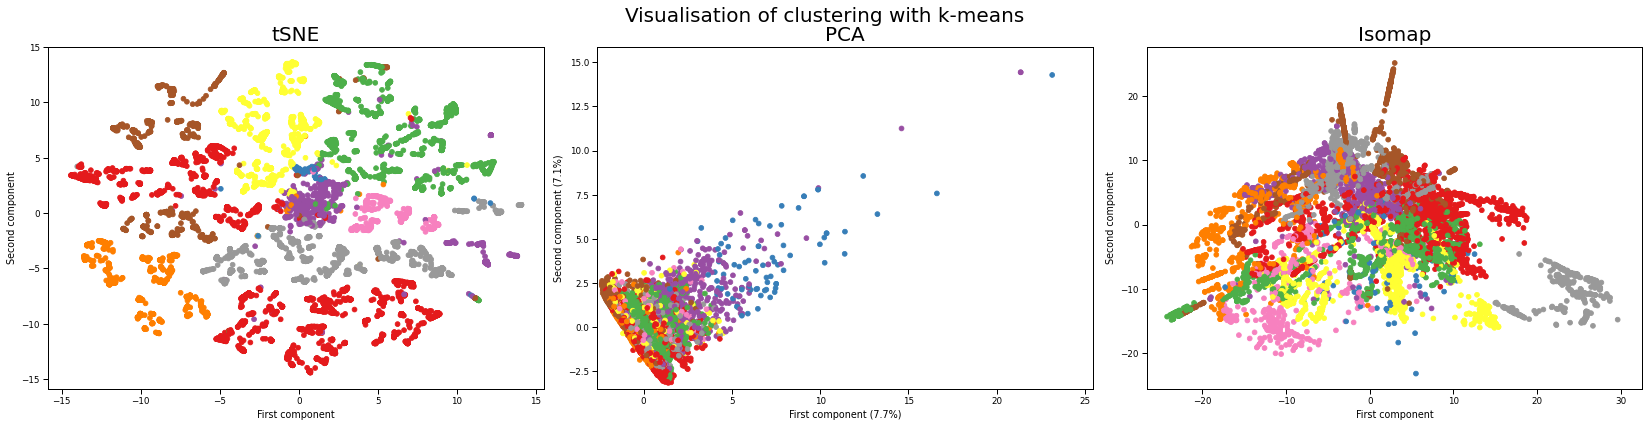

In [95]:
# %%flake8  # checking PEP8 compliance

kmeans = cluster.MiniBatchKMeans(n_clusters=13, random_state=seed)
kmeans.fit(X_std)

# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = kmeans.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [27]:
# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 13

Silhouette coefficient: s = 0.212
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.296
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.691128,0.749100
k-means,13.0,0.211807,0.296462
Naïve model,2.0,-0.000057,0.003700


## **DBSCAN**
*Density-Based Spatial Clustering of Applications with Noise*

### Application de l'algorithme

In [28]:
# %%flake8  # checking PEP8 compliance

# Definition of the search space for hyperparameters
param_grid = {
    # maximum distance that define neighborhood
    'eps': [0.05, 0.1, 0.25, 0.5, 1, 2, 4],
    # nb of neighbors to be considered as a core point
    'min_samples': range(5, 10),
    'n_jobs': [-1]
}

In [29]:
# %%flake8  # checking PEP8 compliance

# importing modules
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
dbscan_search = GridSearch(
    estimator=DBSCAN,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
dbscan_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", dbscan_search.best_params_)
print("Best Silhouette score:", dbscan_search.best_score_)
print("Training time:", dbscan_search.refit_time_)

Best hyperparameters: {'eps': 4, 'min_samples': 7, 'n_jobs': -1}
Best Silhouette score: 0.4346787883276382
Training time: 5.979198217391968


### Influence des hyperparamètres

In [30]:
# %%flake8  # checking PEP8 compliance


def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    import matplotlib

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


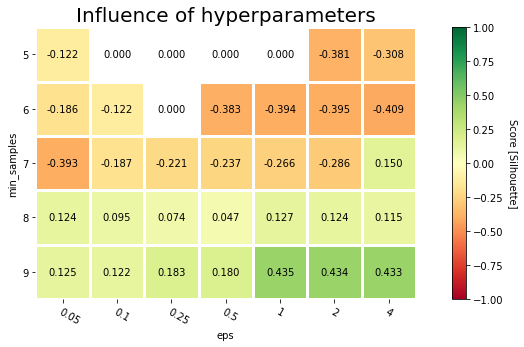

In [31]:
# %%flake8  # checking PEP8 compliance

# Setting labels for parameters
param_1 = [0.05, 0.1, 0.25, 0.5, 1, 2, 4]  # 'eps'
param_2 = range(5, 10)  # 'min_samples'
nb_cols = len(param_1)
nb_rows = len(param_2)

# Getting the list of scores as a np.ndarray
scores = dbscan_search.results_['scores']
scores = np.asarray(scores)
scores = scores.reshape(nb_rows, nb_cols)

# Setting the plot
fig, ax = plt.subplots(figsize=(13, 5))

# from matplotlib import colors
# colors.DivergingNorm(vmin=-1., vcenter=0., vmax=1.)

im, cbar = heatmap(scores,
                   col_labels=param_1,
                   row_labels=param_2,
                   ax=ax,
                   cmap="RdYlGn",
                   cbarlabel="Score [Silhouette]",
                   vmin=-1,
                   vmax=1)

texts = annotate_heatmap(im, valfmt="{x:.3f}")

plt.title("Influence of hyperparameters", fontsize=20)
plt.xlabel('eps')
plt.ylabel('min_samples')

# fig.tight_layout()
plt.show()

In [32]:
pd.DataFrame(dbscan_search.results_)

,scores,params,models,fit_times,nb_clusters,gini_coef
0,-0.122478,"{'eps': 0.05, 'min_samples': 5, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",3.838834,2,0.499500
1,NaN,"{'eps': 0.05, 'min_samples': 6, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",3.833059,1,0.000000
2,NaN,"{'eps': 0.05, 'min_samples': 7, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",3.833554,1,0.000000
3,NaN,"{'eps': 0.05, 'min_samples': 8, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",3.831077,1,0.000000
4,NaN,"{'eps': 0.05, 'min_samples': 9, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",3.831908,1,0.000000
5,-0.380875,"{'eps': 0.1, 'min_samples': 5, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",3.931803,17,0.930176
6,-0.308207,"{'eps': 0.1, 'min_samples': 6, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",3.940563,10,0.893200
7,-0.185761,"{'eps': 0.1, 'min_samples': 7, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",3.932723,3,0.664667
8,-0.122000,"{'eps': 0.1, 'min_samples': 8, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",3.931012,2,0.499200
9,NaN,"{'eps': 0.1, 'min_samples': 9, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",3.932722,1,0.000000


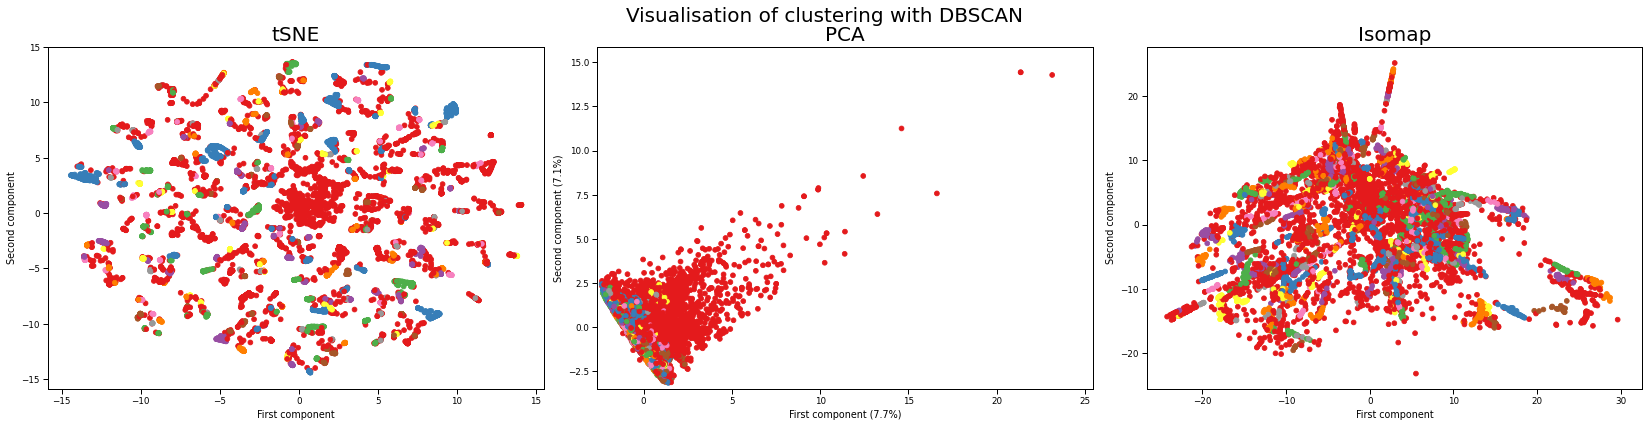

In [96]:
# %%flake8  # checking PEP8 compliance

dbscan = cluster.DBSCAN(eps=1, min_samples=5, n_jobs=-1)
dbscan.fit(X_std)

# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

En jouant sur la valeur des hyper-paramètres eps et min_samples, nous pouvons modifier le nombre de classes trouvées par l'algorithme. Néanmoins, aucunes valeurs de ces hyper-paramètres ne permet de retrouver les 10 clusters du jeu de données initiales. Contrairement au k-means et au clustering hierarchique, DBSCAN ne permet pas de sélectionner le nombre de clusters.

### Réduction dimensionnelle (et visualisation)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: RuntimeWarning:

divide by zero encountered in true_divide



ValueError: ignored

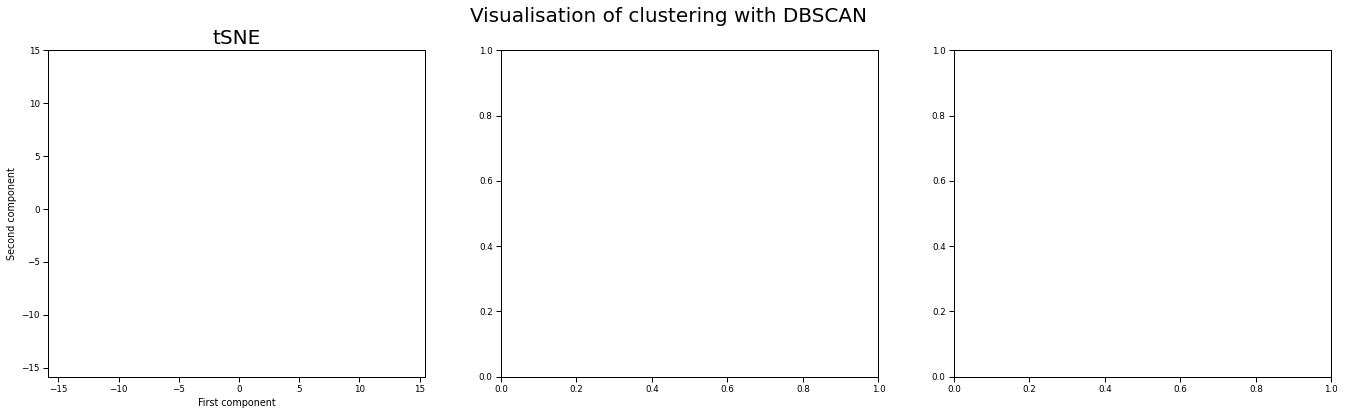

In [97]:
# %%flake8  # checking PEP8 compliance

# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Répartition des effectifs par segments

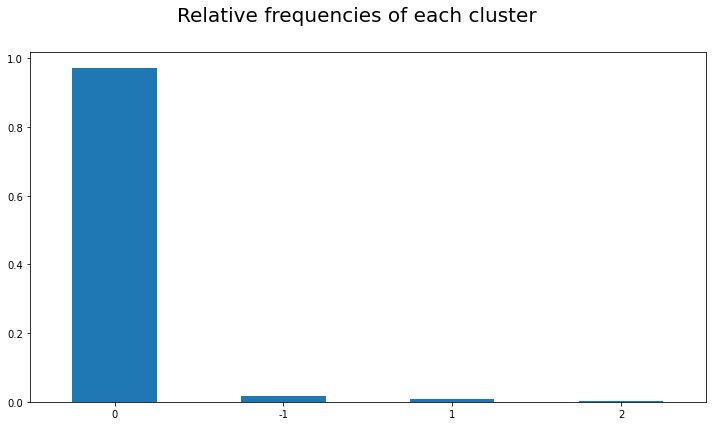

In [35]:
# %%flake8  # checking PEP8 compliance

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Relative frequencies of each cluster', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
labels_counts = pd.Series(clusters_labels).value_counts()\
    / len(clusters_labels)
labels_counts.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig(images_dir + 'clusters_frequencies.png')

### Évaluation de la partition

In [36]:
# %%flake8  # checking PEP8 compliance

# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan_search.best_estimator_.labels_

# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 3

Silhouette coefficient: s = 0.435
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.721
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.691128,0.749100
DBSCAN,3.0,0.434679,0.720800
k-means,13.0,0.211807,0.296462
Naïve model,2.0,-0.000057,0.003700


## **OPTICS**


In [37]:
%%capture --no-stdout --no-display

# importing modules
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

# Definition of the search space for hyperparameters
param_grid = {
    # number of neighbors to be considered as a core point
    'min_samples': [3, 5, 10],
    'xi': [0.05, 0.1, 0.2],
    'min_cluster_size': [0.01, 0.05],
}

# instanciation of the GridSearch object
optics_search = GridSearch(
    estimator=OPTICS,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
optics_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", optics_search.best_params_)
print("Best Silhouette score:", optics_search.best_score_)

Best hyperparameters: {'min_cluster_size': 0.05, 'min_samples': 5, 'xi': 0.1}
Best Silhouette score: 0.7418664315742244


### Réduction dimensionnelle (et visualisation)

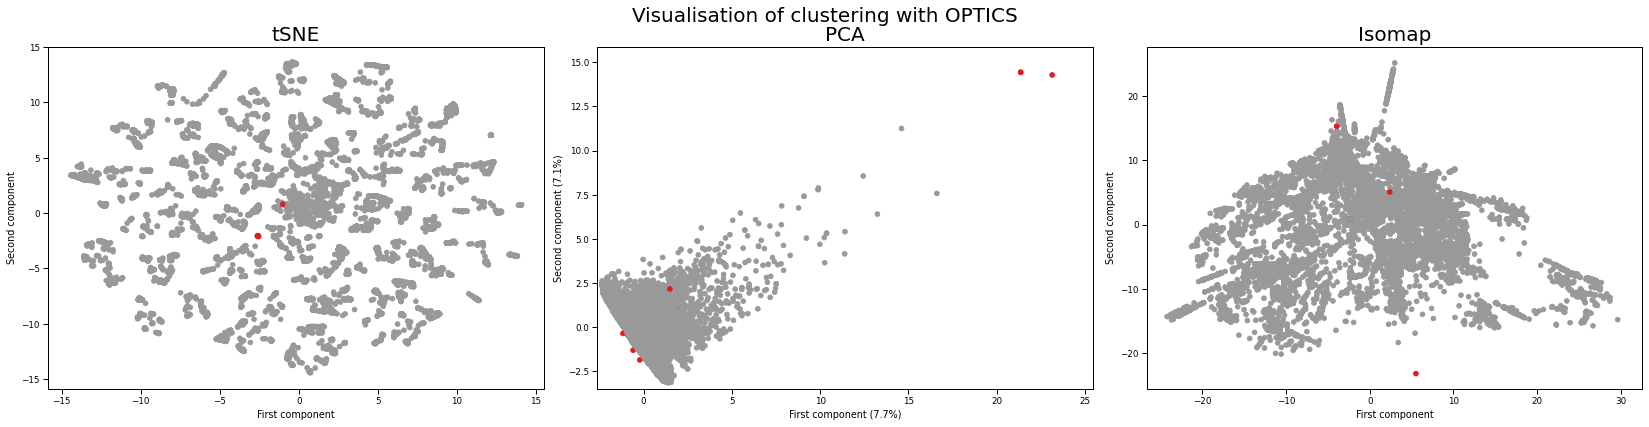

In [98]:
# %%flake8  # checking PEP8 compliance

# Setup for call to the clustering_plots function
algorithm_name = 'OPTICS'
standardized_features = X_std
clusters_labels = optics_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [39]:
# %%flake8  # checking PEP8 compliance

# Setup for call to the clustering_plots function
algorithm_name = 'OPTICS'
standardized_features = X_std
clusters_labels = optics_search.best_estimator_.labels_

# Computes and displays results
metrics_clustering(
    algorithm_name,
    standardized_features,
    clusters_labels,
    results_df
)

Estimated number of clusters (excluding noise): 1

Silhouette coefficient: s = 0.742
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.499
  Notice: values closer to 0 indicate     homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
OPTICS,1.0,0.741866,0.499000
hierarchical clustering,4.0,0.691128,0.749100
DBSCAN,3.0,0.434679,0.720800
k-means,13.0,0.211807,0.296462
Naïve model,2.0,-0.000057,0.003700


Bien qu'ayant un score de Silhouette bas, Le Kmeans semble mieux fonctionner que les autres méthodes de clustering, essayons d'appliquer cet algorithme à l'ensemble du jeu de données.


# Ensemble du jeu de données

## Préparation jeu de donnée complet

In [40]:
X_tot=data_cleaned_std.copy()

## ACP

In [41]:
pca_tot = PCA(random_state=1)

In [42]:
pca_tot.fit(X_tot)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=1,
    svd_solver='auto', tol=0.0, whiten=False)

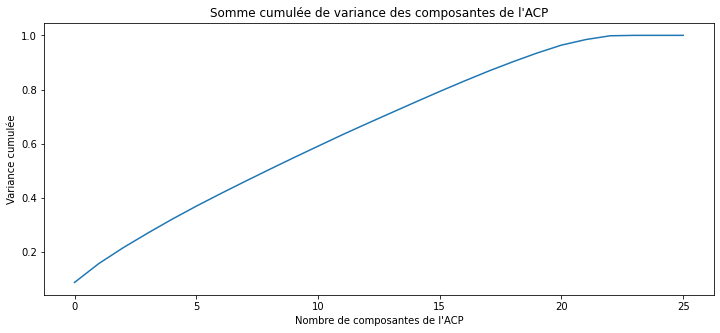

In [43]:
plt.figure(figsize=(12,5))
plt.title('Somme cumulée de variance des composantes de l\'ACP')
plt.xlabel('Nombre de composantes de l\'ACP')
plt.ylabel('Variance cumulée')
plt.plot(list(range(X_tot.shape[1])),
         np.cumsum(pca_tot.explained_variance_ratio_))


In [44]:
np.cumsum(pca_tot.explained_variance_ratio_)[19]

0.9348938527330839

On a  93 % de variance avec 19 features

In [45]:
X_pca_tot = pca_tot.transform(X_tot)[:,:19]

In [46]:
colonnes_pca = X_tot.columns

## Représentation des données

In [47]:
x_show = pca_tot.transform(X_tot.select_dtypes(['float64','int32']))[:,0]

y_show = pca_tot.transform(X_tot.select_dtypes(['float64','int32']))[:,1]

z_show = pca_tot.transform(X_tot.select_dtypes(['float64','int32']))[:,2]

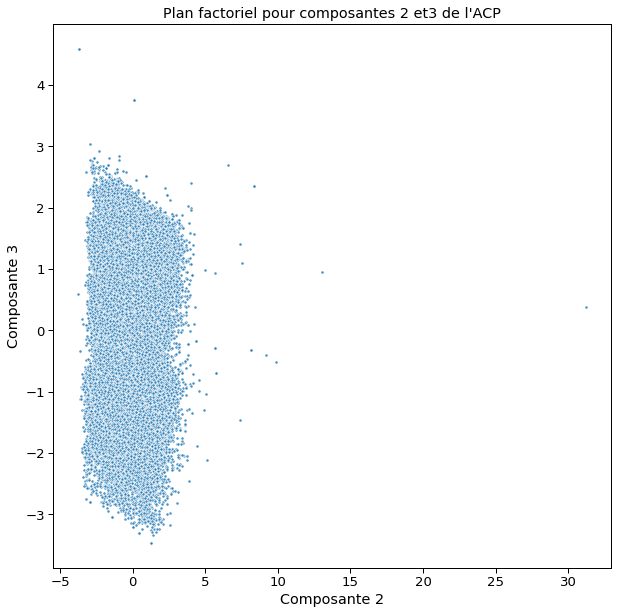

In [48]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10,10))
chaine = "Plan factoriel pour composantes 2 et3 de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 2')
plt.ylabel('Composante 3')
ax = plt.gca()

sns.scatterplot(x = y_show,
                y = z_show,
                #hue = hue_show,
                alpha=0.8, s=10)
i = 0
sns.set_context("paper", font_scale=1) 



## KMeans

Modèle KMeans avec le nombre de clusters optimal identifié sur le jeu de données réduit

In [49]:
kmeans = KMeans(n_clusters=13, 
                verbose=1, 
                random_state=0,
               n_jobs=-1).fit(X_pca_tot)

In [50]:
kmeans.labels_.shape

(98756,)

In [51]:
silhouette_score(X = X_pca_tot, labels= kmeans.labels_)

0.28627581415648734

In [52]:
inertia = {}
dict_kmeans = {}
dict_silhouette = {}
for k in range(12,15):
    kmeans = KMeans(n_clusters=k,
                   verbose=1,
                   random_state=0,
                   n_jobs=-1).fit(X_pca_tot)
    inertia[k] = kmeans.inertia_
    dict_kmeans[k] = kmeans
    dict_silhouette[k] = silhouette_score(X = X_pca_tot, labels= kmeans.labels_)
    print('nbr cluster: {} - Silhouette score : {}'.format(k, dict_silhouette[k]))
    

nbr cluster: 12 - Silhouette score : 0.28233614587678396
nbr cluster: 13 - Silhouette score : 0.28627581415648734
nbr cluster: 14 - Silhouette score : 0.2557131494021363


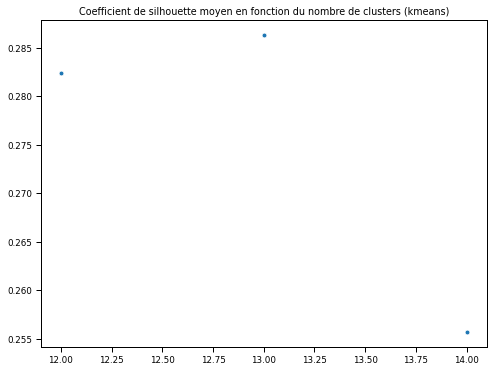

In [53]:
plt.figure(figsize=(8,6)),
plt.title('Coefficient de silhouette moyen en fonction du nombre de clusters (kmeans)')
sns.scatterplot(x = list(dict_silhouette.keys()),
               y = list(dict_silhouette.values()))
plt.show()

Le coefficient de silhouette est maximal pour 13 clusters

## Exports

Exportons notre modèle et notre jeu de données

In [54]:
#export kmeans
filename = 'kmeans_13_full_dataset.obj' 

# Store data (serialize)

with  open(model_dir + filename, 'wb') as filehandler :
    pickle.dump(dict_kmeans[13], filehandler)

# Représentation des variables 

In [55]:
model = dict_kmeans[13]

In [56]:
nb_clusters = 13
if False:
    tsne = TSNE(n_components=2)
    T = tsne.fit_transform(X_pca_tot.copy())
    graph = pd.DataFrame(data = [T[:,0], T[:,1], model.labels_]).T
    graph.columns = ['X', 'Y', 'label']
    plt.figure(figsize=(10,10))
    plt.title('Représentation de la séparation des données du KMEANS via T-SNE')
    sns.scatterplot(graph['X'], graph['Y'], hue = graph['label'], legend='full',
                   palette=sns.color_palette("hls",14),
                    alpha=1, s=15,)
    plt.legend(loc='upper left', labels=graph['label'].unique())
    plt.show()
    
else:
        graph = pd.DataFrame(data = [model.labels_]).T
        graph.columns = ['label']


In [57]:
graph['x_pca'] = x_show
graph['y_pca'] = y_show
graph['z_pca'] = z_show

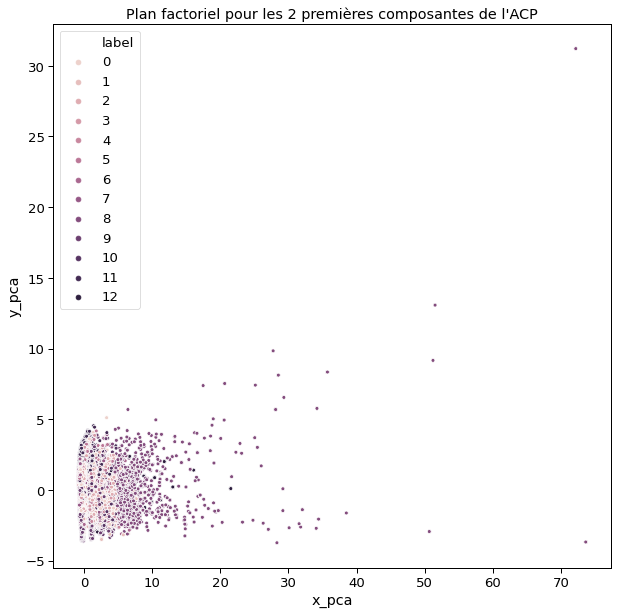

In [58]:
from matplotlib.patches import Circle
sns.set_context("paper", font_scale=1.5) 
plt.figure(figsize=(10,10))
chaine = "Plan factoriel pour les 2 premières composantes de l'ACP"
plt.title(chaine)
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
ax = plt.gca()

sns.scatterplot(x = graph['x_pca'], 
                y = graph['y_pca'], 
                hue = graph['label'],
                alpha=1, s=15, legend='full')

sns.set_context("paper", font_scale=1) 


##Nombres de client par cluster

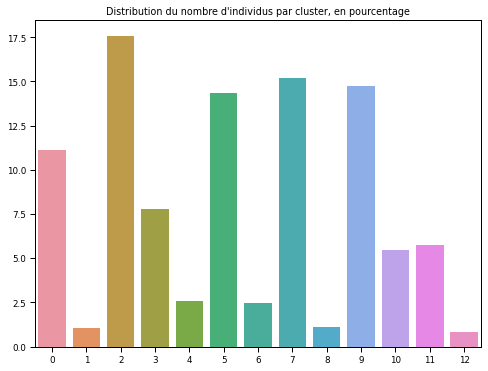

In [59]:
plt.figure(figsize=(8,6))
plt.title('Distribution du nombre d\'individus par cluster, en pourcentage')
sns.barplot(x = graph['label'].value_counts().index, 
           y=graph['label'].value_counts().values/len(graph)*100)

In [60]:
list_clust = graph['label'].value_counts().index
lst_nb = graph['label'].value_counts().values
dict_clust = dict(zip(list_clust, lst_nb))
# Iterate over key/value pairs in dict and print them
for key, value in dict_clust.items():
    print('cluster {} : {} clients'.format(key,value))
print('Sur un total de 98756 clients')

cluster 2 : 17355 clients
cluster 7 : 15007 clients
cluster 9 : 14582 clients
cluster 5 : 14149 clients
cluster 0 : 10994 clients
cluster 3 : 7671 clients
cluster 11 : 5680 clients
cluster 10 : 5397 clients
cluster 4 : 2538 clients
cluster 6 : 2436 clients
cluster 8 : 1114 clients
cluster 1 : 1019 clients
cluster 12 : 814 clients
Sur un total de 98756 clients


## Caractérisation des clusters 

In [61]:
X2=X_tot.copy()

X2['label'] = graph['label']
group_columns = X2.groupby('label').mean()

In [62]:
X_tot_2 = data_cleaned_std.copy()
X_tot_2.head(2)

,nb_purchased_items,nb_orders,mean_price_log,sum_payments,mean_review_score,last_order_purchase_timestamp,cash_payment_percent,credit_card_percent,percentage_review,mean_nb_items_per_order,region_Southeast,season_spring,season_winter,season_summer,season_automn,main_cat_furniture,main_cat_home,main_cat_sports_leisure,main_cat_electronics,main_cat_fashion,main_cat_supplies,main_cat_health_beauty,main_cat_construction,main_cat_misc,main_cat_gifts,main_cat_food_drink
0,-0.296661,-0.200165,0.482929,-0.114998,-0.066376,-1.518127,-0.98733,0.576288,0.044205,-0.273441,0.676214,1.557751,-0.607616,-0.591982,-0.476035,2.148678,-0.365965,-0.416706,-0.425294,-0.16223,-0.294222,-0.431325,-0.244149,-0.164683,-0.248976,-0.104117
1,-0.296661,-0.200165,1.541328,0.162775,0.684083,0.058783,-0.98733,0.576288,0.044205,-0.273441,0.676214,-0.654757,1.675921,-0.591982,-0.476035,-0.476663,2.804758,-0.416706,-0.425294,-0.16223,-0.294222,-0.431325,-0.244149,-0.164683,-0.248976,-0.104117


### CA par cluster

In [63]:
data_cleaned['label'] = model.labels_
CA_data = data_cleaned.groupby('label').sum()

In [64]:
CA_data = CA_data[CA_data.columns[0:4]]
CA_data = CA_data[CA_data.columns[0:4]].sort_values(by=['sum_payments'])

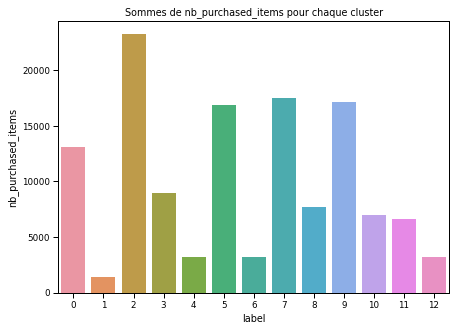

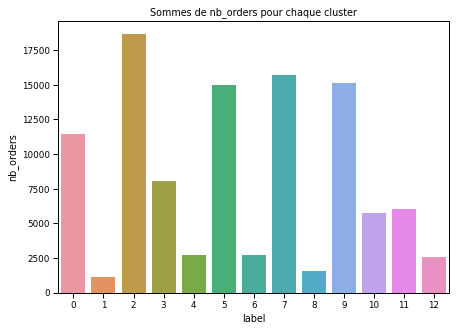

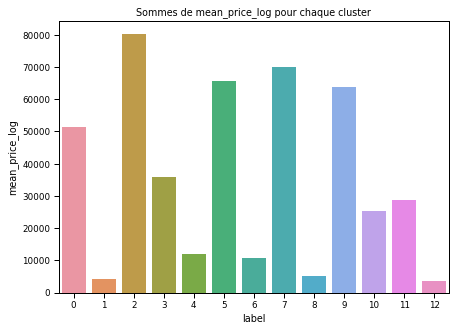

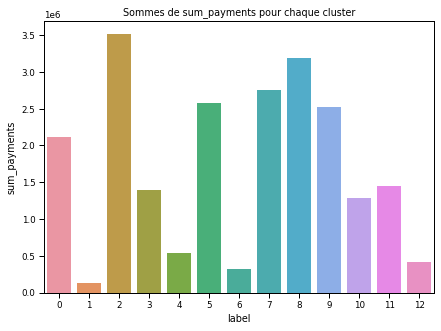

In [65]:
for column in CA_data.columns:
    try:
        plt.figure(figsize=(7,5))
        titre = 'Sommes de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        sns.barplot(x = CA_data.index,
                    y = column,
                    data = CA_data, 
                    ci="sd")
        plt.show()
    except:
        print('Erreur colonne : ', column)

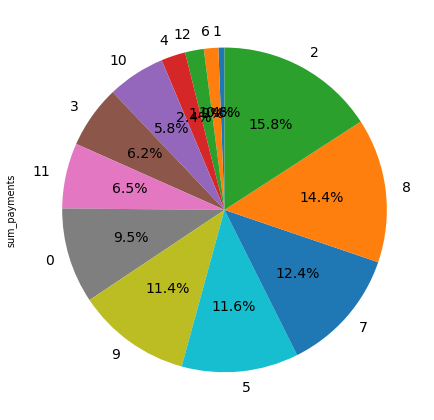

In [66]:
plt.figure(figsize=(16,8))
# plot chart
ax1 = plt.subplot(121, aspect='equal')
CA_data.plot(kind='pie', y = 'sum_payments', ax=ax1, autopct='%1.1f%%', 
 startangle=90, shadow=False, labels=CA_data.index , legend = False, fontsize=14)
plt.show()

Le cluster 2, 8, 7 et 5 représente a eux quatres 54.2% du CA de OLIST.


> Sachant que ce CA est de 22 215 610 Brasilan Real, ces clients on depensser environ 12 million de BRL.


L'équipe marketing devras surement target en priorité ces clients.

En considerant le nombre de client calculer précedament, on peut ce dire qu'il sera particuliérement interessant de target de cluster 8 qui correpond a seulement 1 114 clients.


### Répartition par feature 

#### **Ré-échelonnage** des valeurs (0 à 100) 

---



In [68]:
# %%flake8  # checking PEP8 compliance

from sklearn.preprocessing import MinMaxScaler

# Rescale the features from 0 to 100
scaler = MinMaxScaler(feature_range=(0, 100))


scaled_radar = scaler.fit_transform(X_tot_2)

# Convert back to a pd.DataFrame
features_names = X_tot_2.columns
scaled_radar = pd.DataFrame(scaled_radar, columns=features_names)

In [69]:
scaled_radar.head(2)

,nb_purchased_items,nb_orders,mean_price_log,sum_payments,mean_review_score,last_order_purchase_timestamp,cash_payment_percent,credit_card_percent,percentage_review,mean_nb_items_per_order,region_Southeast,season_spring,season_winter,season_summer,season_automn,main_cat_furniture,main_cat_home,main_cat_sports_leisure,main_cat_electronics,main_cat_fashion,main_cat_supplies,main_cat_health_beauty,main_cat_construction,main_cat_misc,main_cat_gifts,main_cat_food_drink
0,0.0,0.0,40.920107,0.125596,75.0,34.831196,0.0,100.0,40.0,0.0,100.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,53.545964,0.298153,100.0,67.945814,0.0,100.0,40.0,0.0,100.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
scaled_radar['label'] = model.labels_

In [71]:
scaled_radar.describe()

,nb_purchased_items,nb_orders,mean_price_log,sum_payments,mean_review_score,last_order_purchase_timestamp,cash_payment_percent,credit_card_percent,percentage_review,mean_nb_items_per_order,region_Southeast,season_spring,season_winter,season_summer,season_automn,main_cat_furniture,main_cat_home,main_cat_sports_leisure,main_cat_electronics,main_cat_fashion,main_cat_supplies,main_cat_health_beauty,main_cat_construction,main_cat_misc,main_cat_gifts,main_cat_food_drink,label
count,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000,98756.000000
mean,0.414152,0.515817,35.159145,0.197034,77.211173,66.711392,48.878662,75.790578,39.870590,0.538601,68.621653,29.593416,26.608530,25.597431,18.200623,18.156245,11.542014,14.554365,15.134716,2.473229,7.831362,15.444980,5.492046,2.585579,5.747149,1.038314,5.322937
std,1.396051,2.576977,11.929270,0.621219,33.313146,20.999797,49.506132,42.009458,2.927518,1.969722,46.403188,45.197803,43.791942,43.240421,38.233981,38.090483,31.538708,34.927384,35.586663,15.245279,26.617317,35.808363,22.494765,15.700389,23.083258,9.972626,3.420425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,26.740555,0.050694,75.000000,51.822826,0.000000,50.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,0.000000,0.000000,34.382173,0.097683,100.000000,69.397056,0.000000,100.000000,40.000000,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
75%,0.000000,0.000000,42.402847,0.185100,100.000000,83.703181,100.000000,100.000000,40.000000,0.000000,100.000000,100.000000,100.000000,66.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,12.000000


In [72]:
X2=scaled_radar.copy()
group_columns = X2.groupby('label').mean()

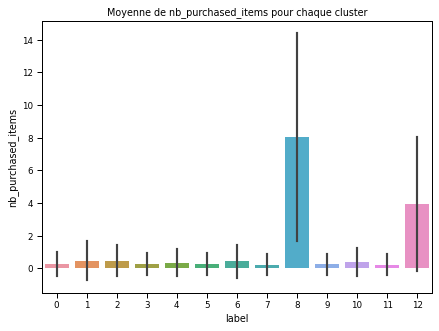

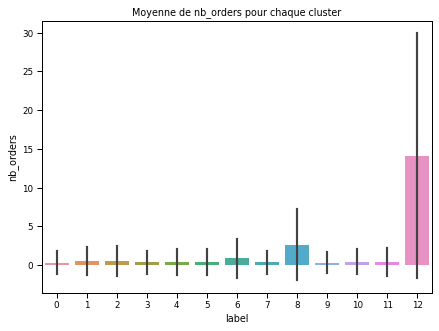

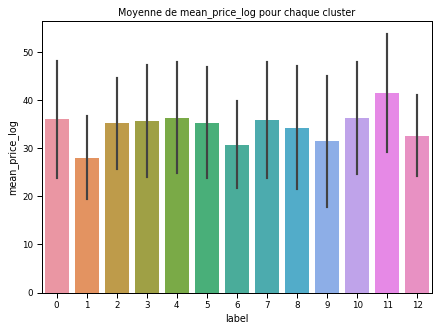

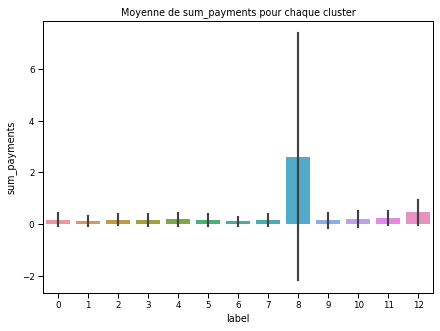

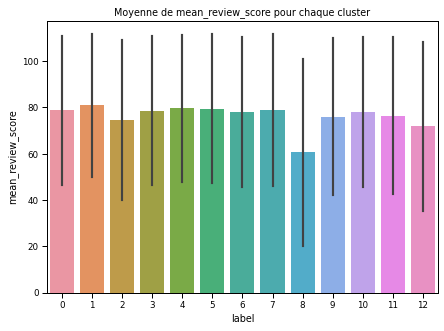

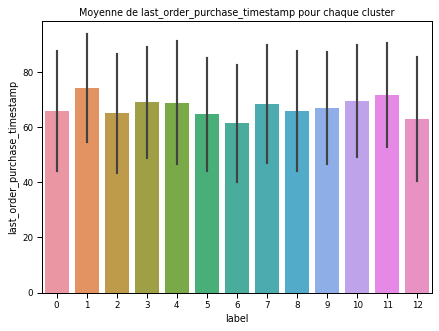

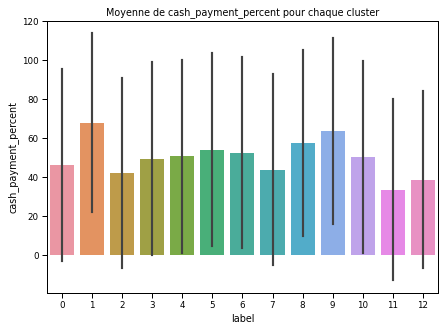

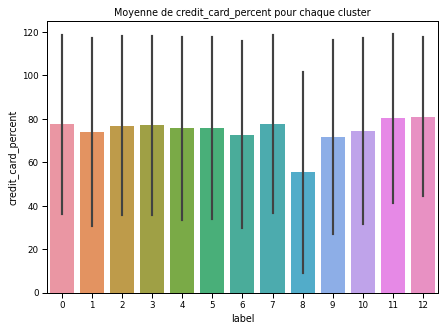

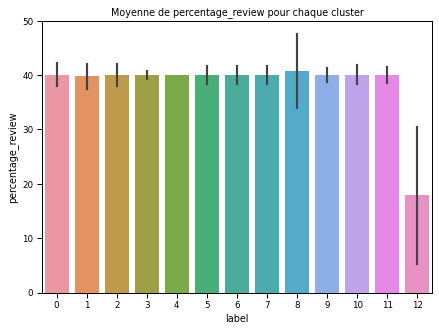

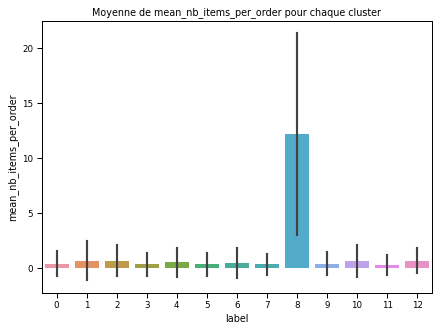

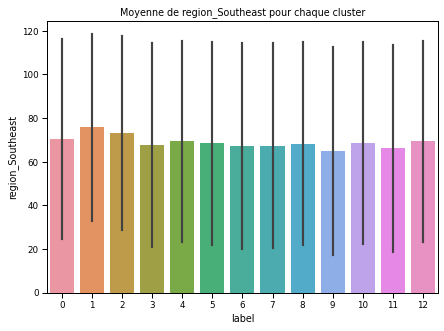

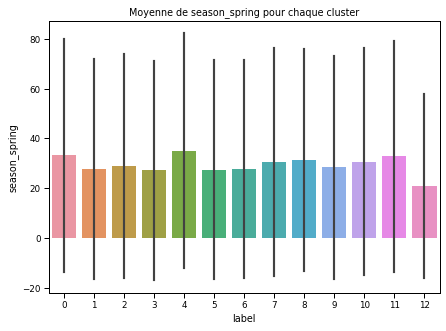

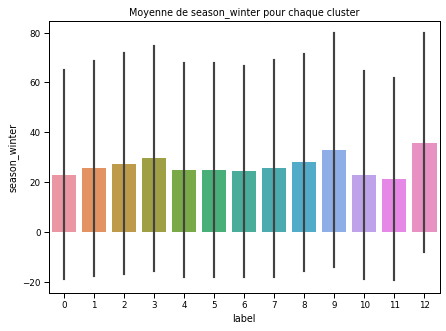

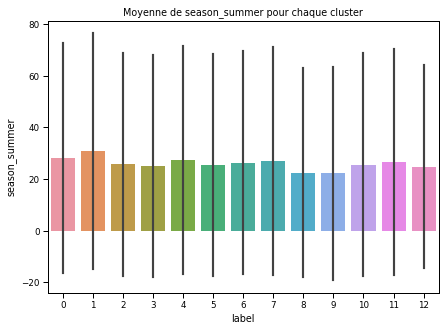

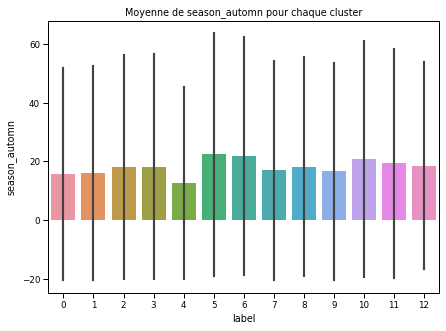

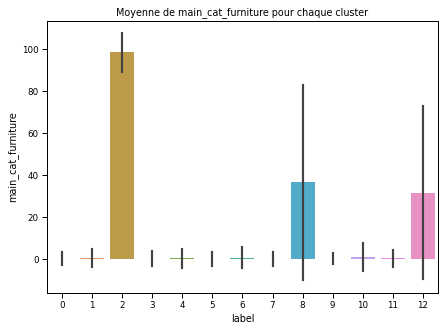

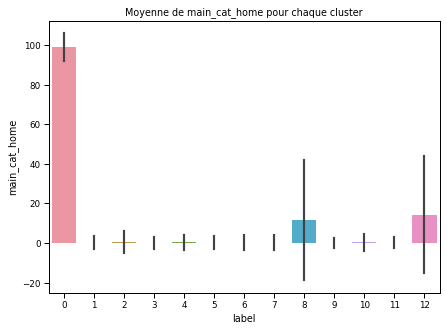

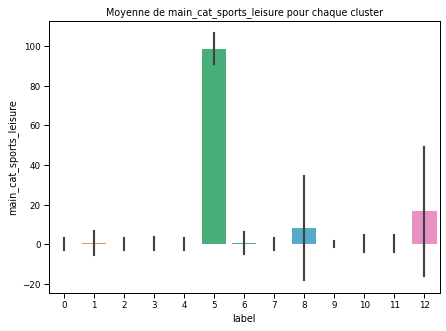

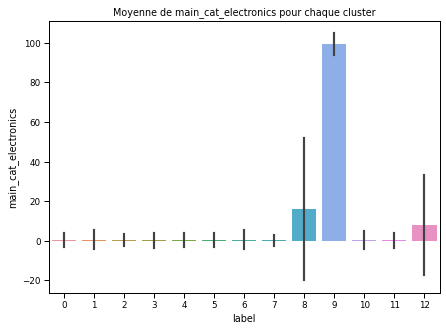

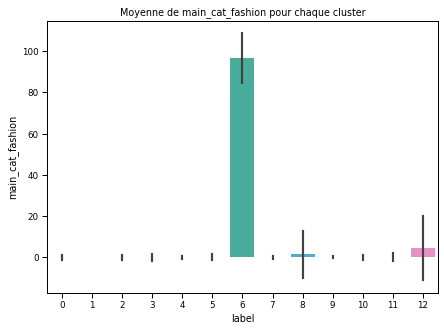

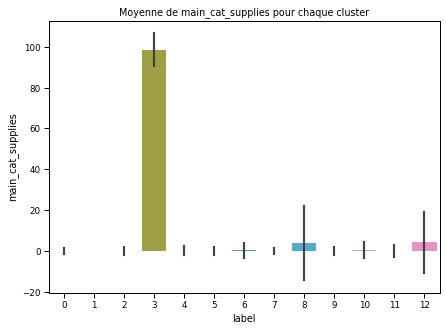

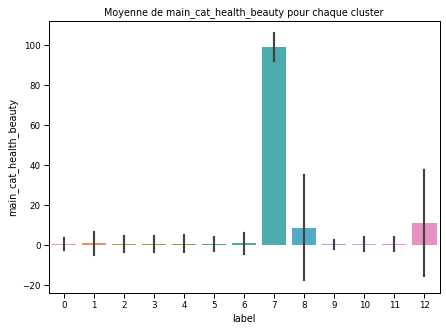

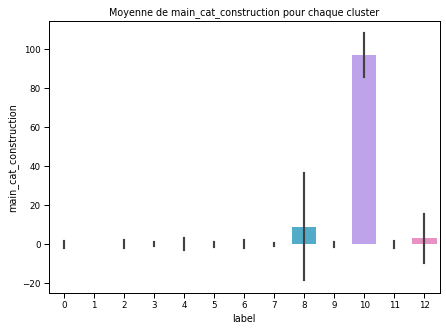

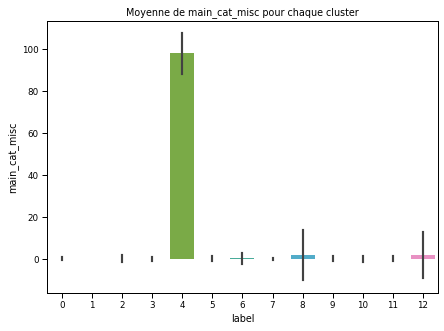

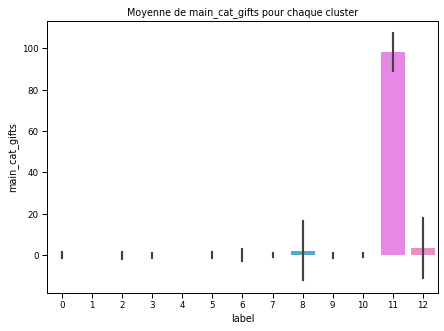

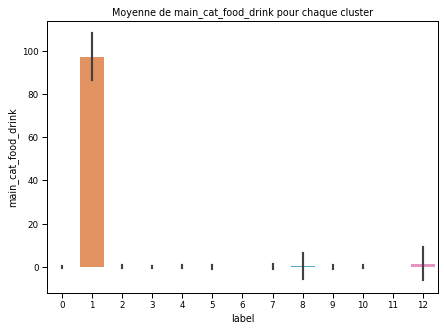

In [108]:
for column in group_columns.columns:
    try:
        plt.figure(figsize=(7,5))
        titre = 'Moyenne de ' + str(column) + ' pour chaque cluster' 
        plt.title(titre)
        fig = sns.barplot(x = 'label',
                    y = column,
                    data = scaled_radar, 
                    ci="sd")
        plt.show()
        out = fig.get_figure()  
        out.savefig(images_dir + 'Moyenne de ' + str(column), dpi=400)
    except:
        print('Erreur colonne : ', column)

On peut déduire de ces histogrammes que nous avons 2 types de cluster. Le premier comprant tout les cluster qui on été former en fonction de leur catégories d'achat.
on peut mettre dans cette catégories les clusters:
* 2 , 0, 5, 9, 6, 3, 7, 10, 4, 11 et 1.

Le deuxieme, comprenant le cluster 8 et 1é correspond plus a un comportement d'achat.
on peut notament dire que:
* Les clients du  cluster 8 achete beaucoup d'item en une fois ( 8 en moyenne)  et on tendance a passer 4 commandes. il sont également moins satisfait que les autres types de clients (satisfactions de 60%) et on tendance a laisser un avis ( 40%).
ils préfairent payer en cash.
Ils achete essantiellement dans la catégorie furniture, mais également dans home et elec.
Ils achéte plutot en hiver et au printemps.

* Les clients du  cluster 12 achete beaucoup d'item en une fois ( 4 en moyenne) et on tendance a passer 14 commandes. 
ils ont une sastifactions "normal" (satisfactions de 80%) mais laisse trés peu de commentaire.
ils préfairent payer par carte.
Ils achete essantiellement dans la catégorie furniture, mais également dans home et sport_leissure.
Ils achéte plutot en hiver (40%).

* les ventes sont en générale plus faible durant l'automne tous cluster confondue ( particluiérement le cluster 4).

* la région n'as pas vraiment d'impact sur le comportement d'achat.

Observation du mode des différents clusters pour chaque feature

In [74]:
scaled_radar.groupby('label').agg(lambda x:x.value_counts().index[0])

,nb_purchased_items,nb_orders,mean_price_log,sum_payments,mean_review_score,last_order_purchase_timestamp,cash_payment_percent,credit_card_percent,percentage_review,mean_nb_items_per_order,region_Southeast,season_spring,season_winter,season_summer,season_automn,main_cat_furniture,main_cat_home,main_cat_sports_leisure,main_cat_electronics,main_cat_fashion,main_cat_supplies,main_cat_health_beauty,main_cat_construction,main_cat_misc,main_cat_gifts,main_cat_food_drink
label,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,37.447209,0.098213,100.0,95.235396,0.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,19.549778,0.023952,100.0,53.735736,100.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
2,0.000000,0.000000,29.632410,0.055177,100.0,80.176716,0.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,33.892791,0.075917,100.0,97.258086,0.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,37.785882,0.100619,100.0,48.531833,100.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
5,0.000000,0.000000,19.790113,0.024482,100.0,59.258431,100.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,26.490123,0.043174,100.0,52.098008,100.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.000000,0.000000,28.696986,0.051343,100.0,49.408434,0.0,100.0,40.000000,0.000000,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
8,6.756757,0.000000,31.209777,1.144808,100.0,89.351519,100.0,100.0,40.000000,13.513514,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
radar =scaled_radar.groupby('label').agg('mean')
radar

,nb_purchased_items,nb_orders,mean_price_log,sum_payments,mean_review_score,last_order_purchase_timestamp,cash_payment_percent,credit_card_percent,percentage_review,mean_nb_items_per_order,region_Southeast,season_spring,season_winter,season_summer,season_automn,main_cat_furniture,main_cat_home,main_cat_sports_leisure,main_cat_electronics,main_cat_fashion,main_cat_supplies,main_cat_health_beauty,main_cat_construction,main_cat_misc,main_cat_gifts,main_cat_food_drink
label,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.259970,0.286217,36.041360,0.167143,78.608825,65.722136,45.931417,77.383724,40.076405,0.371210,70.374750,33.242223,22.980565,28.090928,15.686283,0.219514,98.878328,0.189800,0.265448,0.039567,0.059123,0.199503,0.068219,0.016676,0.053817,0.010005
1,0.453545,0.471050,28.052503,0.112066,80.875859,74.046869,67.721623,73.814197,39.823356,0.631250,75.662414,27.584700,25.556101,30.863124,15.996075,0.408898,0.257333,0.792093,0.523389,0.000000,0.000000,0.686948,0.000000,0.000000,0.000000,97.331339
2,0.462208,0.517430,35.246235,0.176828,74.306540,64.875488,41.759051,76.826275,40.069144,0.641843,73.045232,28.900125,27.426966,25.599827,18.073082,98.160280,0.708345,0.182464,0.201671,0.044752,0.102180,0.335542,0.112456,0.072409,0.066936,0.012965
3,0.231127,0.312867,35.624302,0.156792,78.563855,68.785828,49.266719,76.979316,40.007821,0.311810,67.527050,27.156607,29.560466,25.047799,18.235128,0.247686,0.195542,0.236823,0.290053,0.052144,98.566245,0.312649,0.030418,0.023900,0.040195,0.004345
4,0.339701,0.388758,36.412214,0.184998,79.449862,68.746718,50.351327,75.499081,40.000000,0.487012,69.267139,35.069609,24.890990,27.421198,12.618203,0.436696,0.315209,0.216706,0.286315,0.029551,0.105070,0.404518,0.216706,97.969530,0.000000,0.019701
5,0.256154,0.391547,35.375472,0.158320,79.375398,64.487992,53.875068,75.799703,40.046646,0.325780,68.294579,27.486395,24.890452,25.210733,22.412420,0.248427,0.232761,98.675289,0.276698,0.056541,0.084812,0.290009,0.030626,0.031215,0.045940,0.027682
6,0.425487,0.826492,30.701348,0.111446,78.005146,61.204890,52.149699,72.688150,40.049261,0.439356,67.118227,27.537532,24.380816,26.317148,21.764505,0.574713,0.273673,0.728654,0.501505,96.526116,0.321565,0.637266,0.082102,0.164204,0.190203,0.000000
7,0.224130,0.321628,35.927048,0.159055,78.881772,68.154433,43.580996,77.646765,40.051975,0.290315,67.301926,30.488661,25.649697,26.963084,16.898558,0.237778,0.289865,0.220786,0.164368,0.018880,0.053308,98.943382,0.014438,0.004442,0.018880,0.033873
8,8.030472,2.597247,34.269886,2.614252,60.548785,65.674360,57.366299,55.402023,40.754039,12.164588,68.132855,31.449504,28.000814,22.365423,18.184260,36.418467,11.675187,8.254834,16.078427,1.651706,3.839381,8.545626,9.103824,1.670941,2.280132,0.481475


### **Diagrammes** de Kiviat 

In [76]:
# %%flake8  # checking PEP8 compliance

# Get the name of features
features_names = scaled_radar.columns

# Initializing a pd.DataFrame to store aggregate values
clusters_agg_df = pd.DataFrame(
    columns=[feature_name for feature_name in features_names]
)


# Compute the data for the 'mean customer'
for feature in scaled_radar.columns:
    # compute the mean
    mean_of_feature = scaled_radar[feature].mean()
    clusters_agg_df.loc['mean customer', feature] = mean_of_feature


clusters_agg_df.head(10)

,nb_purchased_items,nb_orders,mean_price_log,sum_payments,mean_review_score,last_order_purchase_timestamp,cash_payment_percent,credit_card_percent,percentage_review,mean_nb_items_per_order,region_Southeast,season_spring,season_winter,season_summer,season_automn,main_cat_furniture,main_cat_home,main_cat_sports_leisure,main_cat_electronics,main_cat_fashion,main_cat_supplies,main_cat_health_beauty,main_cat_construction,main_cat_misc,main_cat_gifts,main_cat_food_drink,label
mean customer,0.414152,0.515817,35.1591,0.197034,77.2112,66.7114,48.8787,75.7906,39.8706,0.538601,68.6217,29.5934,26.6085,25.5974,18.2006,18.1562,11.542,14.5544,15.1347,2.47323,7.83136,15.445,5.49205,2.58558,5.74715,1.03831,5.32294


In [77]:
def columns_interest(dataframe):
  lst_col = []
  for columns in dataframe.columns:
    min = dataframe[columns].min()
    max = dataframe[columns].max()
    dif = max - min
    if min == 0:
      ratio = dif / max
    else:
      ratio = dif / min
    if ratio*100 >= 10:
      lst_col.append(columns)
  return  lst_col


In [101]:
import plotly.graph_objects as go

def kiviat_diagram(dataframe, titl = "Graph radar of all cluster" ):
    #categories = dataframe.columns
    categories = columns_interest(dataframe)
    fig = go.Figure()
    for groups in dataframe.index.tolist():
        fig.add_trace(go.Scatterpolar(
              r=dataframe.loc[groups].tolist(),
              theta=categories,
              fill='toself',
              name= groups
        ))

    fig.update_layout(
      title={
        'text': titl,
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
      polar=dict(
      radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
    showlegend=True
    )

    fig.show()


In [102]:
import plotly.graph_objects as go

def seq_kiviat_diagram(dataframe, titl ="Graph radar for cluster: "):
    categories = columns_interest(dataframe)
    #categories = dataframe.columns

    fig = go.Figure()
    for groups in dataframe.index.tolist():
        fig.add_trace(go.Scatterpolar(
              r=dataframe.loc[groups].tolist(),
              theta=categories,
              fill='toself',
              name= groups
        ))

        fig.update_layout(
          title= titl + str(groups),
          polar=dict(
          radialaxis=dict(
          visible=True,
          range=[0,100]
        )),
        showlegend=True
        )

        fig.show()


In [103]:
import plotly.graph_objects as go


def indiv_kiviat_diagram(dataframe, titl ="Graph radar for cluster: "):
    categories = columns_interest(dataframe)
    #categories = dataframe.columns

    for groups in dataframe.index.tolist():
        fig = go.Figure()
        fig.add_trace(go.Scatterpolar(
              r=dataframe.loc[groups].tolist(),
              theta=categories,
              fill='toself',
              name= groups
        ))

        fig.update_layout(
          title= titl + str(groups),

          polar=dict(
          radialaxis=dict(
          visible=True,
          range=[0,100]
        )),
        #legend_title="Legend Title",
        showlegend=True
        )

        fig.show()


In [104]:
kiviat_diagram(radar)

AttributeError: ignored

In [82]:
my_list = [8, 12]
kiviat_diagram(radar[radar.index.isin(my_list)], titl = "Graph radar of cluster 8 and 12")

In [83]:
my_list = [8, 12]
kiviat_diagram(radar[~radar.index.isin(my_list)], titl = "Graph radar except cluster 8 and 12")

In [84]:
indiv_kiviat_diagram(radar)

Observations : 

* Le cluster 0 correspond aux acheteurs majoritaires de la catégorie 'Home'
* Le cluster 1 correspond aux acheteurs majoritaires de la catégorie 'food_drinks'
* Le cluster 2 correspond aux acheteurs majoritaires de la catégorie 'furniture'
* Le cluster 3 correspond aux acheteurs majoritaires de la catégorie 'supplies'
* Le cluster 4 correspond aux acheteurs majoritaires de la catégorie 'misc'
* Le cluster 5 correspond aux acheteurs majoritaires de la catégorie 'sport_leissure'
* Le cluster 6 correspond aux acheteurs majoritaires de la catégorie 'fashion'
* Le cluster 7 correspond aux acheteurs majoritaires de la catégorie 'health_beauty'
* Le cluster 9 correspond aux acheteurs majoritaires de la catégorie 'elecronics'
* Le cluster 10 correspond aux acheteurs majoritaires de la catégorie 'Construction'
* Le cluster 11 correspond aux acheteurs majoritaires de la catégorie 'gift'

# **Stabilité temporelle** de la segmentation

## **Protocole**

1. fitter l'algorithme de clustering sur une première fraction du jeu de données
2. utiliser la méthode predict sur ce premier lot ; la ségmentation obtenue servira de référence
3. refitter l'algorithme en ajoutant aux données une fraction supplémentaire
4. Utiliser à nouveau la methode predict sur l'échantillon de départ
5. Calculer l'ARI entre la partition initiale et la nouvelle partition

## **Importation** des données clients avec *timestamp*

In [85]:
seed = np.random.seed(42)

In [86]:
#%%flake8  # checking PEP8 compliance

# Get initial data about customers
data_customers = pd.read_csv(dir_name + "p5_data_PCA.csv")

# Sampling
data_customers = data_customers.sample(n=10000, random_state=seed)
data_customers = data_customers.reset_index()

# Get the data about customers, before PCA
data_encoded = pd.read_csv(dir_name + "data_cleaned.csv")

# Get the 'timestamps' of orders
data_timestamps = pd.to_datetime(data_encoded['last_order_purchase_timestamp'])

# Apply the same sampling as data_customers

mask = data_timestamps.index.isin(data_customers.index)
data_timestamps = data_timestamps[mask]

In [87]:
# %%flake8  # checking PEP8 compliance

# Get main temporal informations from data set
date_min = data_timestamps.min()
date_max = data_timestamps.max()
duration = date_max - date_min

print('The data set covers a period of {} days, from {} to {}.'
      .format(duration.days, date_min.date(), date_max.date()))

The data set covers a period of 694 days, from 2016-10-03 to 2018-08-29.


## Évaluation de la stabilité temporelle

In [88]:
# %%flake8  # checking PEP8 compliance

def time_stability(model, nb_iter=5, init_centroid=False):

    from datetime import datetime, timedelta
    from sklearn.metrics.cluster import adjusted_rand_score
    from sklearn import cluster

    # Setting the initial data set to one year of data
    date_init = date_min + timedelta(days=365)

    # Getting the initial data set
    timemask = (data_timestamps < date_init)
    X_init = data_customers[timemask]

    # Standardization and PCA of the dataset...
    X_init_std = X_init

    # Fitting the model on intial data
    model.fit(X_init_std)

    # Predicting the initial clusters labels for initial customers
    clusters_init = model.labels_

    if init_centroid == True:
        # Save the centroids for further initialisations
        cluster_centers = model.cluster_centers_

    # Initializations
    ARI_results = pd.DataFrame()
    index = -1
    date_lim = date_init

    # Iterating until we reach the maximum date in data set
    while date_lim < date_max:
        index +=1
        # getting the new data truncated
        timemask = (data_timestamps < date_lim)
        X_trunc = data_customers[timemask]

        # standardisation and PCA
        X_trunc_std = X_trunc

        # iterating for stability and standard deviation of scores
        # --------------------------------------------------------
        ARI_scores = []

        for i in range(nb_iter):

            # From 1st month, set the initial centroids
            if index == 1 & init_centroid == True:
                model.set_params(init=cluster_centers, n_init=1, random_state=None)

            # fitting a new model on the truncated data
            model.fit(X_trunc_std)

            # Creating a mask for customers in initial partition
            list_init = X_init_std.index
            mask = X_trunc_std.index.isin(list_init)

            # Getting the labels for the initial customers
            clusters_new = model.labels_[mask]

            # Computing and saving ARI score between initial clustering and new ones
            ARI_score = adjusted_rand_score(clusters_init, clusters_new)
            ARI_scores.append(ARI_score)

            # Add timestamp and ARI scores to the results pd.DataFrame
            ARI_results.loc[index, 'period'] = date_lim # - date_init
            ARI_results.loc[index, 'ARI_score_mean'] =  np.mean(ARI_scores)
            ARI_results.loc[index, 'ARI_score_std'] =  np.std(ARI_scores)

        # increase timelimit by 30 days for next iteration
        date_lim += timedelta(days=30)

    return ARI_results

In [89]:
# %%flake8  # checking PEP8 compliance

# Initialising with random seed
kmeans_search.best_estimator_.set_params(init='k-means++', random_state=seed)

# Getting results of time stability for each model
hierarchy_stability = time_stability(model=hierarchy_search.best_estimator_)
kmeans_stability = time_stability(
    model=kmeans_search.best_estimator_,
    init_centroid=True
)
dbscan_stability = time_stability(model=dbscan_search.best_estimator_)

# Setting back the kmeans_search
kmeans_search.best_estimator_.set_params(init='k-means++', random_state=seed)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
                init_size=None, max_iter=100, max_no_improvement=10,
                n_clusters=12, n_init=1, random_state=None,
                reassignment_ratio=0.01, tol=0.0, verbose=0)

## **Visualisation** de l'évolution du modèle de partitionnement

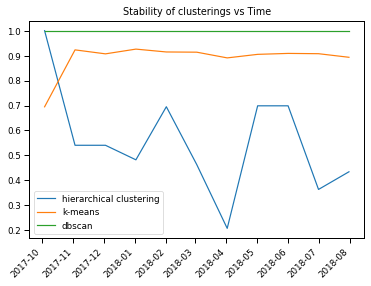

In [90]:
# %%flake8  # checking PEP8 compliance

x = hierarchy_stability['period']
plt.plot(
    x,
    hierarchy_stability['ARI_score_mean'],
    label='hierarchical clustering'
)
plt.plot(x, kmeans_stability['ARI_score_mean'], label='k-means')
plt.plot(x, dbscan_stability['ARI_score_mean'], label='dbscan')
plt.legend()
plt.title("Stability of clusterings vs Time")
plt.xticks(rotation='45', horizontalalignment="right")
plt.show()

Les segments sont relativement stables au cours du temps pour KMEANs et dbscan.
on vois que on a tout de même une légere variations avec Kmeans de maniére periodique. on peut donc réentrainer le model tout les 2 a 3 mois. 

# Résultats et problématique

Au vue des analyses eyant été effectué nous pouvont recommander au equipe marketing de ce concentrer sur les clusters 2, 8, 7 et 5 qui représente a eux quatres 54.2% du CA de OLIST.

il faudras donc chercher a mettre en avant des produits correspondant au catégories d'intéret respective a tous ces clusters en visant particuliérement la satisfactions client du cluster 8, actuellement faible, qui regroupant seulement 1 114 clients , compte pour 14,4% du CA de OLIST.

il est également interessant de noter que ces clusters seront plus actif en hiver. 


Malgrés ces recomendations il est important de noté que les résultats ne sont pas parfaitement satisfaisants vis à vis de la problématique:  
> Le clustering suit principalement les catégories de produits prédéfinies. On aurait pu faire ce tri sans faire appel à des algorithmes 

La base de données permet de faire difficilement mieux par des algorithmes traditionnels car peu de clients ont fait plusieurs achats, ce qui limite le nombre de possibilités qu'on peut envisager (fréquence des achats, complémentarité des catégories d'achats, date du dernier achat, etc.)